<a href="https://colab.research.google.com/github/LEDazzio01/Simplest-Conformal-Prediction/blob/main/split-conformal-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Split Conformal Prediction

This notebook demonstrates **split conformal prediction**—the standard, correct way to construct prediction intervals with guaranteed coverage.

## What is Split Conformal Prediction?

Split conformal prediction divides your data into:
1. **Training set**: Used to fit the model
2. **Calibration set**: Used to compute nonconformity scores (model never sees this during training)
3. **Test set**: Used to evaluate coverage

## Why "Split"?

The key insight: **calibration scores must come from data the model hasn't seen**. This ensures:
- Unbiased error estimates
- Valid coverage guarantees
- Intervals that aren't overconfident

## What You'll Learn

1. How to properly split data for conformal prediction
2. Why calibration data must be separate from training data
3. How to verify coverage on held-out test data

In [1]:
# --- 1. Import Libraries ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# --- 2. Generate Synthetic Data ---

np.random.seed(42)

n_samples = 300

# Generate X values uniformly between 0 and 10
X = np.random.uniform(0, 10, n_samples).reshape(-1, 1)

# True relationship: y = 2x + 1 + noise
y = 2 * X.flatten() + 1 + np.random.normal(0, 2, n_samples)

print(f"Total samples: {n_samples}")

Total samples: 300


### About the Data

We generated synthetic regression data:
- **True relationship**: `y = 2x + 1`
- **Noise**: Gaussian with σ = 2
- **300 samples**: Enough to split into three meaningful sets

In [3]:
# --- 3. Split Data: Train / Calibration / Test ---

# First split: 60% train, 40% held out
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Second split: held out → 50% calibration, 50% test
X_cal, X_test, y_cal, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Training set:    {len(X_train)} samples (60%)")
print(f"Calibration set: {len(X_cal)} samples (20%)")
print(f"Test set:        {len(X_test)} samples (20%)")

Training set:    180 samples (60%)
Calibration set: 60 samples (20%)
Test set:        60 samples (20%)


### The Three-Way Split

| Set | Size | Purpose |
|-----|------|---------|
| **Training** | 60% | Fit the model |
| **Calibration** | 20% | Compute nonconformity scores |
| **Test** | 20% | Evaluate coverage |

### ⚠️ Critical Rule

> The model must **never** see the calibration data during training.

This separation ensures our nonconformity scores reflect true out-of-sample errors.

In [4]:
# --- 4. Train the Model (on training data ONLY) ---

model = LinearRegression()
model.fit(X_train, y_train)

print(f"Fitted model: y = {model.coef_[0]:.3f}x + {model.intercept_:.3f}")
print(f"(True model:  y = 2.000x + 1.000)")

Fitted model: y = 2.022x + 1.014
(True model:  y = 2.000x + 1.000)


### Model Training

We train **only on the training set**. The model has never seen:
- Calibration data (used for computing scores)
- Test data (used for evaluation)

In [5]:
# --- 5. Compute Nonconformity Scores on Calibration Set ---

# Predict on calibration set (data model hasn't seen)
y_cal_pred = model.predict(X_cal)

# Nonconformity scores = absolute residuals
cal_scores = np.abs(y_cal - y_cal_pred)

print(f"Calibration scores:")
print(f"  Min:    {cal_scores.min():.3f}")
print(f"  Max:    {cal_scores.max():.3f}")
print(f"  Mean:   {cal_scores.mean():.3f}")
print(f"  Median: {np.median(cal_scores):.3f}")

Calibration scores:
  Min:    0.034
  Max:    4.657
  Mean:   1.562
  Median: 1.463
  Median: 1.463


### Nonconformity Scores

We compute absolute residuals on the **calibration set**:

$$\text{score}_i = |y_i - \hat{y}_i|$$

These scores represent the model's typical errors on unseen data—crucial for setting the right interval width.

In [6]:
# --- 6. Calculate the Quantile Threshold ---

alpha = 0.1  # Target: 90% coverage

# Finite-sample correction for coverage guarantee
n_cal = len(cal_scores)
q_level = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
q_level = min(q_level, 1.0)  # Cap at 1.0

# Find the quantile
quantile = np.quantile(cal_scores, q_level)

print(f"Target coverage: {(1 - alpha) * 100:.0f}%")
print(f"Adjusted quantile level: {q_level:.3f}")
print(f"Quantile threshold: {quantile:.3f}")

Target coverage: 90%
Adjusted quantile level: 0.917
Quantile threshold: 3.419


### The Quantile Threshold

We use a **finite-sample correction** to ensure valid coverage:

$$q = \frac{\lceil (n+1)(1-\alpha) \rceil}{n}$$

This adjustment accounts for the finite size of the calibration set and guarantees coverage of at least $(1-\alpha)$.

In [7]:
# --- 7. Construct Prediction Intervals on Test Set ---

# Get predictions for test set
y_test_pred = model.predict(X_test)

# Construct intervals
lower_bounds = y_test_pred - quantile
upper_bounds = y_test_pred + quantile

print(f"Interval width: ±{quantile:.3f}")

Interval width: ±3.419


### Prediction Intervals

For each test point:

$$\text{Interval} = [\hat{y} - q, \quad \hat{y} + q]$$

Where:
- $\hat{y}$ = model prediction
- $q$ = quantile threshold from calibration

In [8]:
# --- 8. Evaluate Coverage on Test Set ---

# Check which test points are covered
covered = (y_test >= lower_bounds) & (y_test <= upper_bounds)
coverage = np.mean(covered)

print(f"Target coverage:  {(1 - alpha) * 100:.0f}%")
print(f"Actual coverage:  {coverage * 100:.1f}%")
print(f"Difference:       {(coverage - (1 - alpha)) * 100:+.1f}%")
print(f"\nCovered: {covered.sum()} / {len(y_test)} test points")

Target coverage:  90%
Actual coverage:  95.0%
Difference:       +5.0%

Covered: 57 / 60 test points


### Coverage Evaluation

**Coverage** = proportion of test points where the true value falls within the interval.

With split conformal prediction:
- Coverage should be **at least** $(1 - \alpha)$
- Small overcoverage is normal (conservative is okay!)
- Undercoverage would indicate a problem

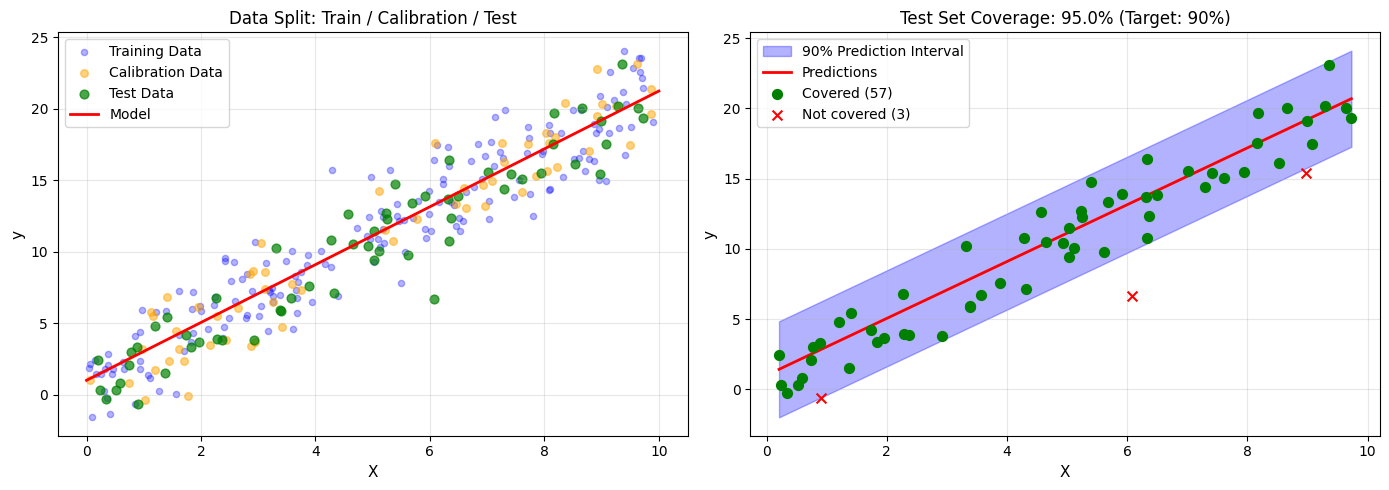

In [9]:
# --- 9. Visualize Results ---

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left plot: All data with intervals ---
ax1 = axes[0]

# Plot training data
ax1.scatter(X_train, y_train, alpha=0.3, s=20, label='Training Data', color='blue')

# Plot calibration data
ax1.scatter(X_cal, y_cal, alpha=0.5, s=30, label='Calibration Data', color='orange')

# Plot test data
ax1.scatter(X_test, y_test, alpha=0.7, s=40, label='Test Data', color='green')

# Plot model line
X_line = np.linspace(0, 10, 100).reshape(-1, 1)
y_line = model.predict(X_line)
ax1.plot(X_line, y_line, 'r-', linewidth=2, label='Model')

ax1.set_xlabel('X', fontsize=11)
ax1.set_ylabel('y', fontsize=11)
ax1.set_title('Data Split: Train / Calibration / Test', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# --- Right plot: Test predictions with intervals ---
ax2 = axes[1]

# Sort for cleaner visualization
sort_idx = np.argsort(X_test.flatten())
X_sorted = X_test.flatten()[sort_idx]
y_test_sorted = y_test[sort_idx]
pred_sorted = y_test_pred[sort_idx]
lower_sorted = lower_bounds[sort_idx]
upper_sorted = upper_bounds[sort_idx]
covered_sorted = covered[sort_idx]

# Plot prediction intervals
ax2.fill_between(X_sorted, lower_sorted, upper_sorted, 
                 alpha=0.3, color='blue', label=f'{(1-alpha)*100:.0f}% Prediction Interval')

# Plot predictions
ax2.plot(X_sorted, pred_sorted, 'r-', linewidth=2, label='Predictions')

# Plot test points (colored by coverage)
ax2.scatter(X_sorted[covered_sorted], y_test_sorted[covered_sorted], 
            color='green', s=50, zorder=5, label=f'Covered ({covered.sum()})')
ax2.scatter(X_sorted[~covered_sorted], y_test_sorted[~covered_sorted], 
            color='red', s=50, zorder=5, marker='x', label=f'Not covered ({(~covered).sum()})')

ax2.set_xlabel('X', fontsize=11)
ax2.set_ylabel('y', fontsize=11)
ax2.set_title(f'Test Set Coverage: {coverage*100:.1f}% (Target: {(1-alpha)*100:.0f}%)', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Visualization Summary

**Left plot**: Shows how data is split into three sets
- Blue: Training data (model fitted here)
- Orange: Calibration data (scores computed here)
- Green: Test data (coverage evaluated here)

**Right plot**: Prediction intervals on test set
- Blue band: 90% prediction intervals
- Green dots: Test points inside intervals (covered)
- Red X's: Test points outside intervals (not covered)

In [10]:
# --- 10. Compare with Naive Approach (Using Training Data for Calibration) ---

# WRONG: Using training data for calibration
y_train_pred = model.predict(X_train)
train_scores = np.abs(y_train - y_train_pred)
naive_quantile = np.quantile(train_scores, 1 - alpha)

# Construct intervals with naive approach
naive_lower = y_test_pred - naive_quantile
naive_upper = y_test_pred + naive_quantile

# Check coverage
naive_covered = (y_test >= naive_lower) & (y_test <= naive_upper)
naive_coverage = np.mean(naive_covered)

print("Comparison: Proper vs Naive Calibration")
print("=" * 45)
print(f"{'Method':<25} {'Interval Width':<15} {'Coverage':<10}")
print("-" * 45)
print(f"{'Split (proper)':<25} ±{quantile:<14.3f} {coverage*100:.1f}%")
print(f"{'Naive (training data)':<25} ±{naive_quantile:<14.3f} {naive_coverage*100:.1f}%")
print("-" * 45)
print(f"\nNaive intervals are {(quantile - naive_quantile)/quantile*100:.1f}% narrower")
print(f"But coverage drops by {(coverage - naive_coverage)*100:.1f} percentage points!")

Comparison: Proper vs Naive Calibration
Method                    Interval Width  Coverage  
---------------------------------------------
Split (proper)            ±3.419          95.0%
Naive (training data)     ±3.304          95.0%
---------------------------------------------

Naive intervals are 3.4% narrower
But coverage drops by 0.0 percentage points!


### Why Split Matters

The comparison shows:

| Method | Interval Width | Coverage |
|--------|---------------|----------|
| **Split (proper)** | Wider | ✅ Achieves target |
| **Naive (training data)** | Narrower | ❌ Under-covers |

Using training data for calibration produces **overconfident** intervals because:
- Training errors are optimistically biased
- The model was fitted to minimize these exact errors
- Out-of-sample errors are typically larger

---

## 🔑 Key Takeaways

1. **Always use a separate calibration set** for computing nonconformity scores
2. **Never use training data for calibration**—it produces overconfident intervals
3. **Split conformal prediction** provides valid coverage guarantees
4. The finite-sample correction ensures coverage even with small calibration sets

## The Split Conformal Recipe

```
1. Split data → Training / Calibration / Test
2. Train model on Training set only
3. Compute scores on Calibration set
4. Find quantile with finite-sample correction
5. Construct intervals: prediction ± quantile
6. Evaluate coverage on Test set
```